In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List, Union

In [2]:
from matplotlib import font_manager


sns.set_theme(style="white", rc={"grid.color": "lightgray"})
plt.rc("axes", titlesize=16, titleweight="bold", labelsize=14, labelweight="bold")
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
FONT = font_manager.FontProperties(weight='bold')

In [4]:
def get_non_pareto_dominated_inds(candidates: Union[np.ndarray, List], remove_duplicates: bool = True) -> np.ndarray:
    """A batched and fast version of the Pareto coverage set algorithm.

    Args:
        candidates (ndarray): A numpy array of vectors.
        remove_duplicates (bool, optional): Whether to remove duplicate vectors. Defaults to True.

    Returns:
        ndarray: The indices of the elements that should be kept to form the Pareto front or coverage set.
    """
    candidates = np.array(candidates)
    uniques, indcs, invs, counts = np.unique(candidates, return_index=True, return_inverse=True, return_counts=True, axis=0)

    res_eq = np.all(candidates[:, None, None] <= candidates, axis=-1).squeeze()
    res_g = np.all(candidates[:, None, None] < candidates, axis=-1).squeeze()
    c1 = np.sum(res_eq, axis=-1) == counts[invs]
    c2 = np.any(~res_g, axis=-1)
    if remove_duplicates:
        to_keep = np.zeros(len(candidates), dtype=bool)
        to_keep[indcs] = 1
    else:
        to_keep = np.ones(len(candidates), dtype=bool)

    return np.logical_and(c1, c2) & to_keep


def filter_pareto_dominated(candidates: Union[np.ndarray, List], remove_duplicates: bool = True) -> np.ndarray:
    """A batched and fast version of the Pareto coverage set algorithm.

    Args:
        candidates (ndarray): A numpy array of vectors.
        remove_duplicates (bool, optional): Whether to remove duplicate vectors. Defaults to True.

    Returns:
        ndarray: A Pareto coverage set.
    """
    candidates = np.array(candidates)
    if len(candidates) < 2:
        return candidates
    return candidates[get_non_pareto_dominated_inds(candidates, remove_duplicates=remove_duplicates)]


In [5]:
from pymoo.indicators.hv import HV

def get_hv(points, ref_point):
    return HV(ref_point=ref_point * -1)(np.array(points) * -1)

# MineCart

In [6]:
gpils_path = "minecart/gpils-pareto.csv"
gpi_pareto = pd.read_csv(gpils_path)

dylam_paths = [
    "minecart/dylam_objective_1.csv",
    "minecart/dylam_objective_2.csv",
    "minecart/dylam_objective_3.csv",
]
dylam_dfs = [pd.read_csv(path) for path in dylam_paths]
dylam = np.zeros((len(dylam_dfs[0]), len(dylam_dfs)))
for i, df in enumerate(dylam_dfs):
    dylam[:, i] = df.values[:, 1]

dylam_pareto = filter_pareto_dominated(dylam)

In [7]:
ref_point = np.array([-1, -1, -1000])
hvs = {
    algo: (get_hv(values, ref_point), len(values))
    for algo, values in [
        ("GPI-LS", gpi_pareto[["objective_1", "objective_2", "objective_3"]].values),
        ("DyLam", dylam_pareto),
    ]
}
for algo, (hv, cardinality) in hvs.items():
    print(f"{algo} HV(log10): {np.log(hv)} | Cardinality: {cardinality}")

GPI-LS HV(log10): 8.196497312305702 | Cardinality: 500
DyLam HV(log10): 8.714289123131962 | Cardinality: 32


In [8]:
dylam_weights = [pd.read_csv(f"minecart/dylam_weight_{i}.csv") for i in range(3)]
dylam_weights = [dylam_weights[i][f"env: MINECART - lambdas/component_{i}"] for i in range(3)]
dylam_weights = pd.DataFrame({"First_Minerium": dylam_weights[0], "Second_Minerium": dylam_weights[1], "Fuel": dylam_weights[2]})
gpi_ls_weights = pd.read_csv("minecart/gpi_ls_weights.csv")

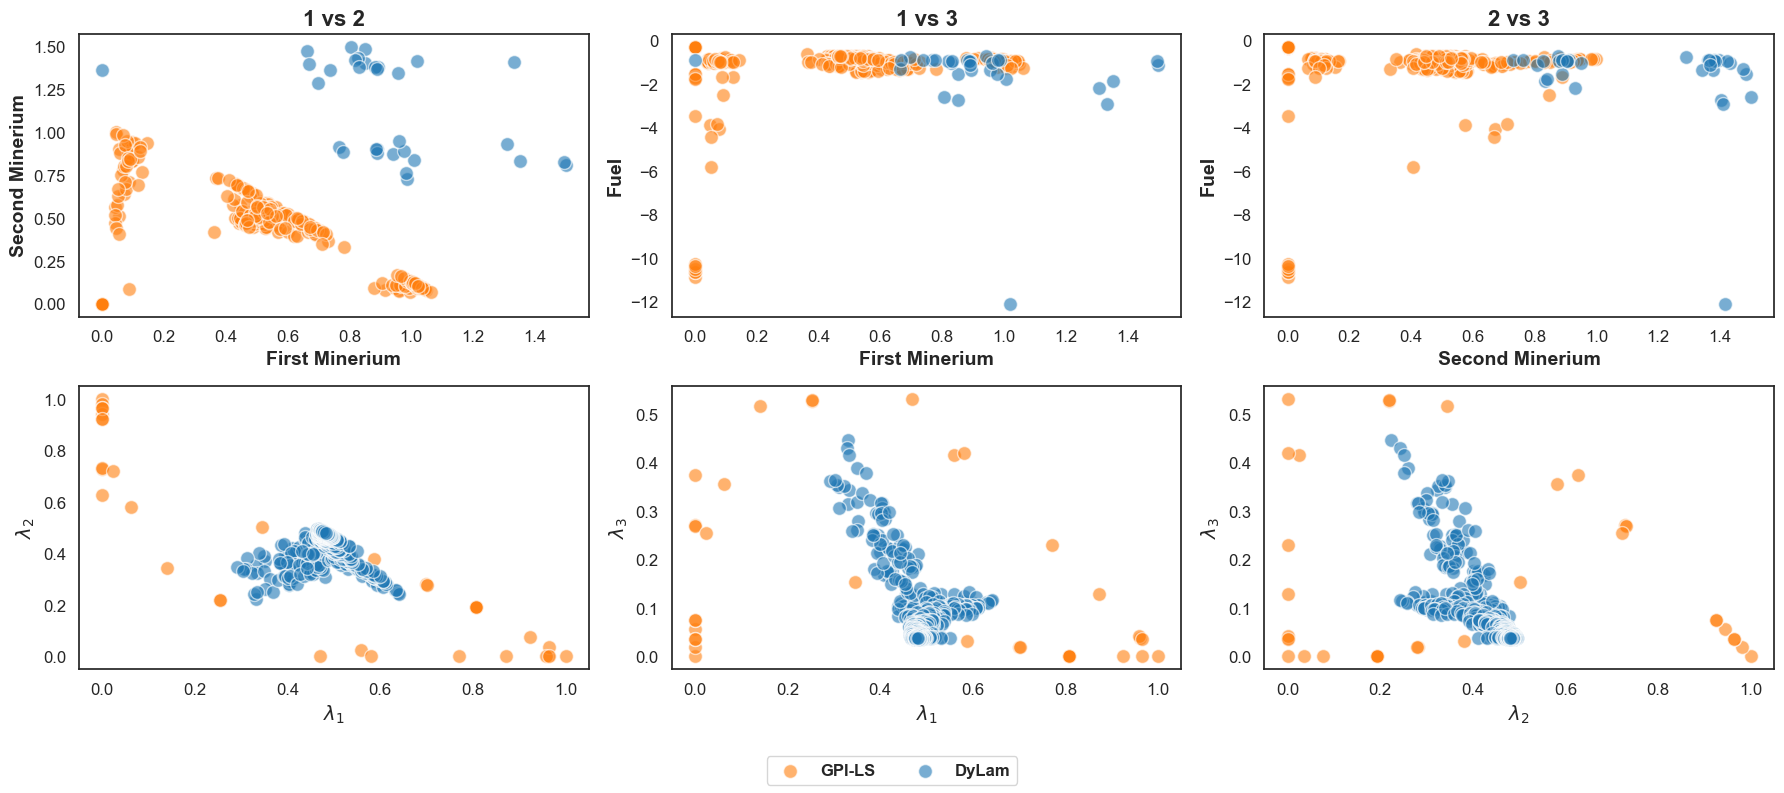

In [26]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(18, 8),
)

combinations = [(1, 2), (1, 3), (2, 3)]
combinations_map = [("First_Minerium", "Second_Minerium"), ("First_Minerium", "Fuel"), ("Second_Minerium", "Fuel")]


for col, (i, j) in enumerate(combinations):
    ax = axes[0, col]
    ax.scatter(
        gpi_pareto[f"objective_{i}"],
        gpi_pareto[f"objective_{j}"],
        label="GPI-LS",
        color="tab:orange",
        alpha=0.6,
        edgecolors="w",
        s=100,
    )
    ax.scatter(
        dylam_pareto[:, i-1],
        dylam_pareto[:, j-1],
        label="DyLam",
        color="tab:blue",
        alpha=0.6,
        edgecolors="w",
        s=100,
    )
    ax.set_xlabel(combinations_map[col][0].replace("_", " "))
    ax.set_ylabel(combinations_map[col][1].replace("_", " "))
    ax.set_title(f"{i} vs {j}")


for col, (i, j) in enumerate(combinations):
    ax = axes[1, col]
    ax.scatter(
        gpi_ls_weights[combinations_map[col][0]],
        gpi_ls_weights[combinations_map[col][1]],
        label="GPI-LS",
        color="tab:orange",
        alpha=0.6,
        edgecolors="w",
        s=100,
    )
    ax.scatter(
        dylam_weights[combinations_map[col][0]],
        dylam_weights[combinations_map[col][1]],
        label="DyLam",
        color="tab:blue",
        alpha=0.6,
        edgecolors="w",
        s=100,
    )
    ax.set_xlabel(f"$\lambda_{i}$")
    ax.set_ylabel(f"$\lambda_{j}$")
    
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, prop=FONT)

fig.tight_layout(rect=[0, 0.06, 1, 1])
plt.savefig("minecart/minecart_pareto_weights.pdf", format="pdf", bbox_inches="tight")